In [1]:
# for viewing the original setup code, refer to 
# https://github.com/facebookresearch/detectron2
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=15182fe67ce7fee26004785f8a36a13ce14a9594f452cea3d4231a62d44618d0
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 574 kB/s 
     |████████████████████████████████| 49 kB 2.6 MB/s 
     |████████████████████████████████| 130 kB 9.8 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 145 kB 49.3 MB/s 
     |████████████████████████████████| 749 kB 33.0 MB/s 
     |████████████████████████████████

In [1]:
# Some basic setup:
# Setup detectron2 logger
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
from skimage import measure
# detect MAs
def num_MA3(path,file,predictor):
    im = cv2.imread(os.path.join(path,file))
    sz = im.shape
    MASK1=np.zeros(sz[0:2],dtype=np.uint8)
    MASK2=np.zeros(sz[0:2],dtype=np.uint8)
    i0=round(sz[0]/2)
    j0=round(sz[1]/2)
    i4=round(sz[0]/4)-1
    j4=round(sz[1]/4)-1
    a0=[0, 0, i0,   i0,    0, i4,   i4,   i4,    i0]#[0, 0, 0, i4,   i4,   i4,   i0,   i0,   i0]
    a1=[i0,i0,sz[0],sz[0],i0, i0+i4,i0+i4,i0+i4, sz[0]]#[i0,i0,i0,i0+i4,i0+i4,i0+i4,sz[0],sz[0],sz[0]]
    b0=[0, j0,   j0,   0, j4,   0, j4,   j0,   j4]#[0, j4,   j0,   0, j4,   j0,   0, j4,   j0]
    b1=[j0,sz[1],sz[1],j0,j4+j0,j0,j4+j0,sz[1],j4+j0]#[j0,j4+j0,sz[1],j0,j4+j0,sz[1],j0,j4+j0,sz[1]]
    for ii in range(9):
        im1=im[a0[ii]:a1[ii],b0[ii]:b1[ii],]
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        outputs = predictor(im1)
        masks = outputs['instances'].pred_masks.to('cpu').numpy()
        classes = outputs['instances'].pred_classes.to('cpu').numpy()
        #print(len(classes))
        for jj in range(len(classes)):
            #print(MASK1[a0[ii]:a1[ii],b0[ii]:b1[ii]].shape,masks[jj,:,:].shape)
            if classes[jj]==0:
                MASK1[a0[ii]:a1[ii],b0[ii]:b1[ii]]=MASK1[a0[ii]:a1[ii],b0[ii]:b1[ii]]+masks[jj,:,:]
            elif classes[jj]==1:
                MASK2[a0[ii]:a1[ii],b0[ii]:b1[ii]]=MASK2[a0[ii]:a1[ii],b0[ii]:b1[ii]]+masks[jj,:,:]

    blobs = (MASK1 > 0)
    all_labels1, num1 = measure.label(blobs, return_num=True, background=0)
    blobs = (MASK2 > 0)
    all_labels, num2= measure.label(blobs, return_num=True, background=0)
    #print(num1,num2)
    #blobs_labels = measure.label(blobs, background=0)
    #print(len(all_labels),num)
    MASK1[MASK1>0]=1
    return num1,MASK1,all_labels1 # number of MAs, mask(MA as 1, others 0)

In [3]:
from PIL import Image, ImageDraw # (pip install Pillow)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)
def DrawDetectedMA(image1,mask,color='blue',width=5):
    contours = measure.find_contours(np.array(mask), 0.5, positive_orientation='low')
    for contour in contours:
        # Flip from (row, col) representation to (x, y) and subtract the padding pixel
        for i in range(len(contour)):         # (n,2)-ndarrays
            row, col = contour[i]             # Flip from (row, col)
            contour[i] = (col - 1, row - 1)   # subtract the padding pixel
            # Make a polygon and simplify it
        poly = Polygon(contour)
        image1.line(np.array(poly.exterior.coords).ravel().tolist(),fill=color,width=width)
        print(color,width)
    return image1

In [4]:
%matplotlib inline
print(torch.__version__, torch.cuda.is_available())
# make sure that gpu is available

1.10.0+cu111 False


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [9]:
''' faster
down load trained models and images from kaggle
https://www.kaggle.com/adamhuan/modelsdiabeticretinopathy
to get modelsdiabeticretinopathy.zip using API kaggle.json (need to get a new kaggle.json to download the files everytime)
https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
'''
#copy kaggle.json to colab platform and run
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download adamhuan/modelsdiabeticretinopathy
! unzip modelsdiabeticretinopathy.zip

''' slower
or download archive.zip and move it to colab's gdrive, then run
! unzip archive.zip
to get
./images/DS000DGS.JPG
./images/DS000DGS.png
./models/model_final.pth
./models/best_resnext_model_ft_DR512.pth

'''

mkdir: cannot create directory ‘/root/.kaggle’: File exists
modelsdiabeticretinopathy.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  modelsdiabeticretinopathy.zip
replace images/DS000DGS.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: images/DS000DGS.JPG     
  inflating: images/DS000DGS.png     
  inflating: models/best_resnext_model_ft_DR512.pth  
  inflating: models/model_final.pth  


" slower\nor download archive.zip and move it to colab's gdrive, then run\n! unzip archive.zip\nto get\n./images/DS000DGS.JPG\n./images/DS000DGS.png\n./models/model_final.pth\n./models/best_resnext_model_ft_DR512.pth\n\n"

In [10]:
cfg.OUTPUT_DIR = "./models"

In [11]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
cfg.TEST.DETECTIONS_PER_IMAGE=120
if torch.cuda.is_available()==False:
  cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

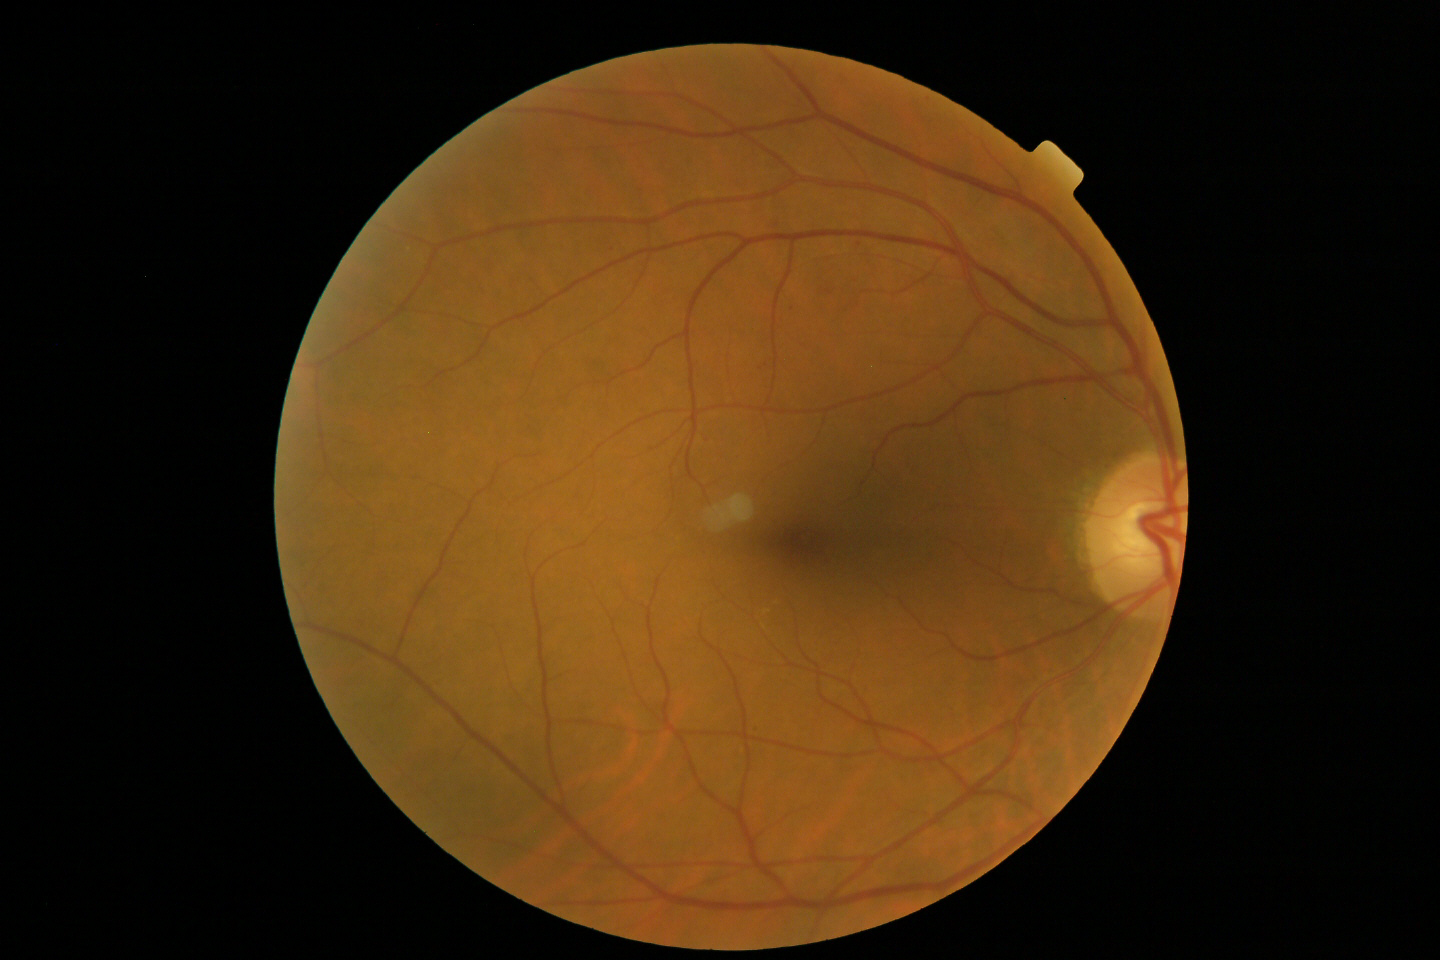

In [12]:
im = Image.open("./images/DS000DGS.JPG")
im

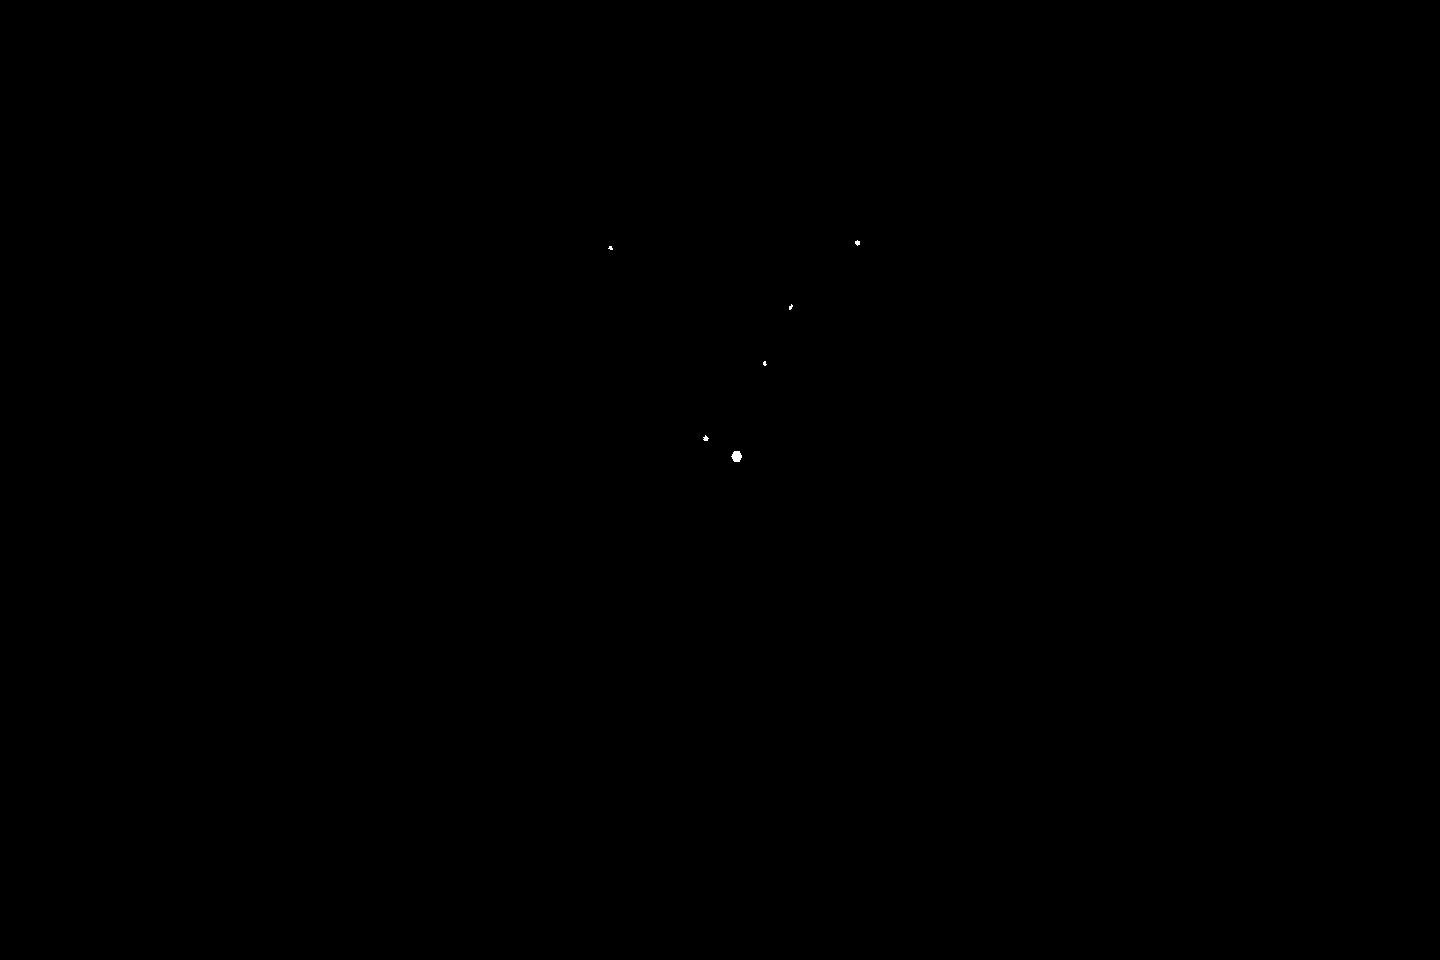

In [13]:
# read the ground truth (e_ophtha dataset)
# read one image
msk = Image.open("./images/DS000DGS.png")
msk

In [14]:
num1,MASK1,all_labels1 = num_MA3("./images","DS000DGS.JPG",predictor)
print("*********************************")
print('Number of detected MAs =' ,num1)
print("*********************************")

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


*********************************
Number of detected MAs = 6
*********************************


blue 20
blue 20
blue 20
blue 20
blue 20
blue 20
yellow 3
yellow 3
yellow 3
yellow 3
yellow 3
yellow 3


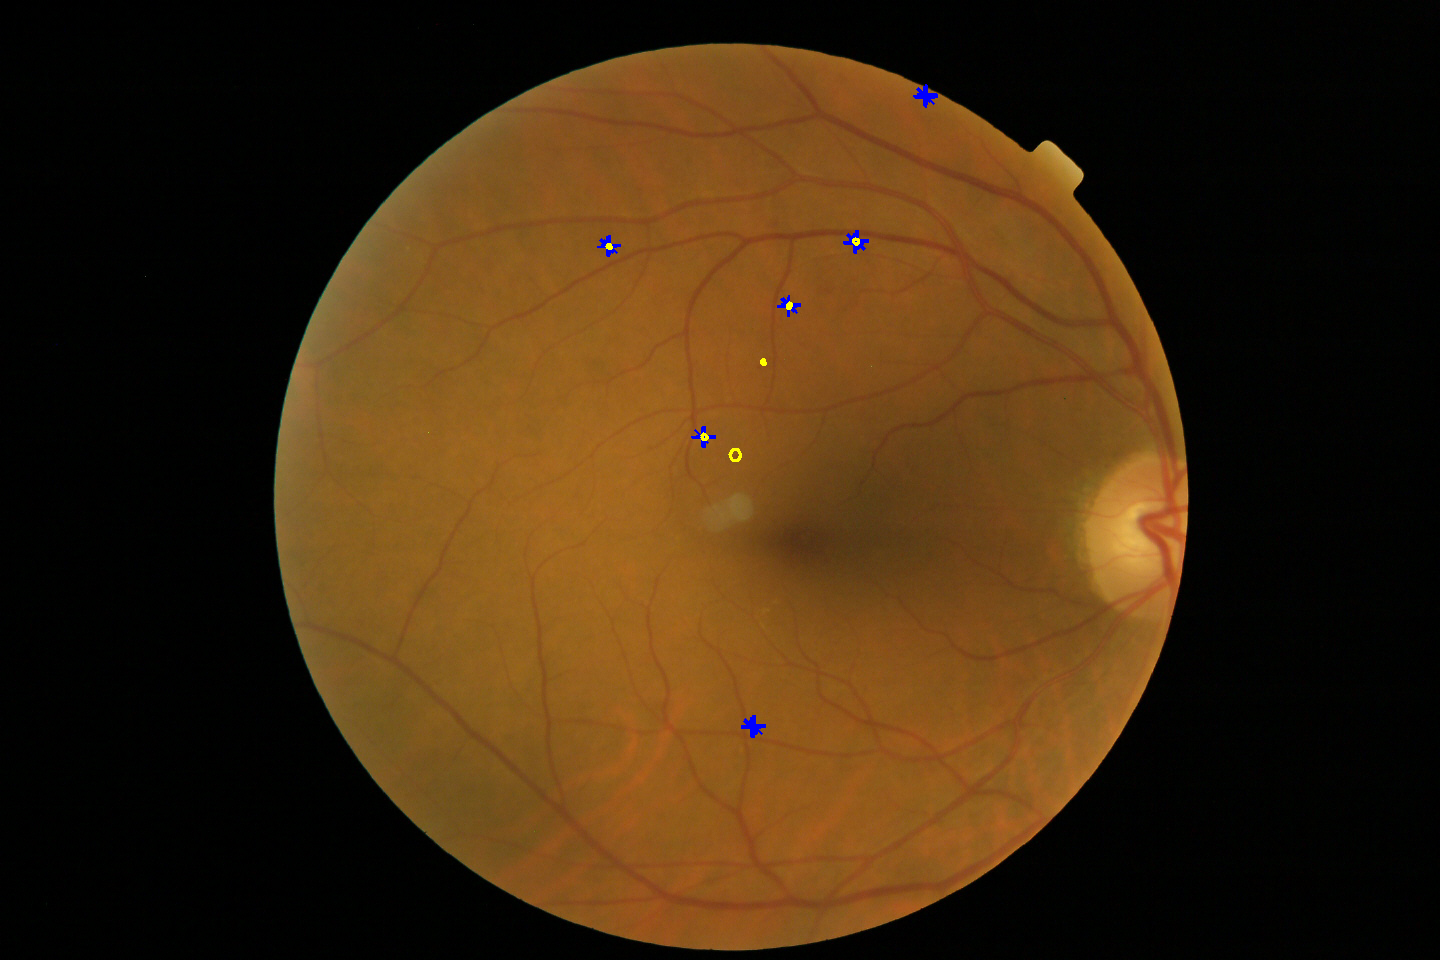

In [15]:
image=Image.open("./images/DS000DGS.JPG")
msk = Image.open("./images/DS000DGS.png")
image1=ImageDraw.Draw(image)
image1=DrawDetectedMA(image1,MASK1,'blue',20)# blue: by Detectron2
image1=DrawDetectedMA(image1,msk,'yellow',3)# yellow: ground truth
image